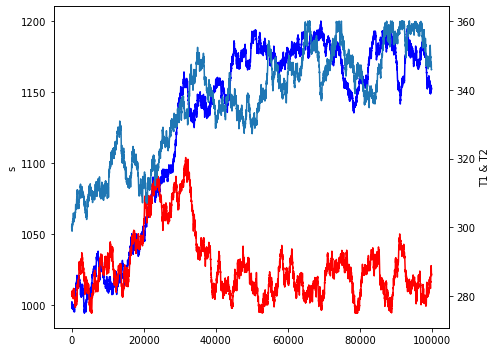

Estimate of s: 1177.7108183014866
Estimate of T1: 295.97607953594945
Estimate of T2: 349.3386480472811
90% interval for T1: 287.1957593191476 to 320.28611876678445
90% interval for T2: 339.7841969095752 to 359.9962995927125


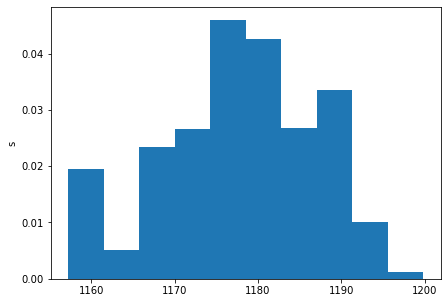

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import scipy.integrate as integrate
from scipy.stats import norm, gamma, uniform
class Mcmc_3D:

    def __init__(self, bounds, displacements, prior_rvs, filename, phys_model):

        # Possible values of random variable X
        self.xbounds  = np.array(bounds[0])
        self.ybounds  = np.array(bounds[1])
        self.zbounds  = np.array(bounds[2])
        
        # Initialize a random number generator
        self.prng     = np.random.default_rng()

        # Max displacements for every degree of freedom
        self.displacements = displacements

        # Store the list of prior random variables as an attribute
        self.prior_rvs = prior_rvs

        # Load measured data from file
        self.T = np.loadtxt(filename)
        self.physical_model = phys_model
    

    def get_log_prior(self,u):
    # chose the prior to be uniformly distributed
        log_prior = 0
        
        for i, p_rv in enumerate(self.prior_rvs):
            log_prior += math.log(p_rv.pdf(u[i]))
        
        
        return log_prior

        
    
    def get_log_likelihood(self, u):

        # Computes log likelihood from data
        
        
        log_likelihood  = self.physical_model(self.T,u)
        
        return log_likelihood

    
    

    
    def get_log_posterior(self, u):

        # Get log posterior from log prior and log likelihood

        return self.get_log_prior(u) + self.get_log_likelihood(u)

    
    # Get value of log f at state u where f is the pdf
    def get_log_f_val(self, u):
        
        # Compute log of posterior
        return self.get_log_posterior(u)
    
    # Random walk
    def get_next_pos (self, u_cur):
        
        u_new = np.copy(u_cur)

        # Pick one of the three random variables
        i_var = self.prng.choice(3)

        # Displace this random variable
        u_new[i_var] = u_cur[i_var] + self.displacements[i_var]*self.prng.uniform (low = -1, high = 1)
        
        return u_new
        
    def make_plot(self, states):

        # Makes a plot of the trajectory
        
        fig, ax1 = plt.subplots(figsize = (7,5))

        ax2 = ax1.twinx()
        
        n, a = states.shape
        
        ax1.plot(10*np.arange(n)+1, states[:,0], color = "b")
        ax2.plot(10*np.arange(n)+1, states[:,1], color = "r")
        ax2.plot(10*np.arange(n)+1, states[:,2])
        
        ax1.set_ylabel("s")
        ax2.set_ylabel("T1 & T2")
        #ax1.set_xlabel('MCS')

        plt.tight_layout()
        #plt.savefig('trajec.pdf')
        plt.show()
        
    def check_bounds(self, u_cur):

        # Returns False if walker is out of bounds
        
        if u_cur[0] > self.xbounds[-1] or u_cur[0] < self.xbounds[0]:
            return False
        
        if u_cur[1] > self.ybounds[-1] or u_cur[1] < self.ybounds[0]:
            return False
        
        if u_cur[2] > self.zbounds[-1] or u_cur[2] < self.zbounds[0]:
            return False
        
        return True
    
    def run_mc(self, u0, nsteps = 200):

        # Main MC loop
        u_old          = np.array(u0, dtype = np.float64)
        
        states = []
        parameter1 = []
        parameter2 = []
        parameter3 = []
        
        for istep in range(nsteps):

            # Compute f at current u
            log_f_old = self.get_log_f_val(u_old)

            # Propose a new u
            u_new  = self.get_next_pos (u_old)

            # Reject the move if bounds are exceeded
            if not self.check_bounds(u_new):
                continue
            
            # Compute f at new u
            log_f_new = self.get_log_f_val (u_new)

            del_log_f = log_f_new - log_f_old
            
            # Compute acceptance factor
            # if del_log_f is larger than zero accenptance factor will be one

            if del_log_f > 0:
                acc_factor = 1
            else:
                acc_factor = math.exp(log_f_new - log_f_old)

            # Proposal probabilities are equal both ways

            # Accept/Reject proposal
            if (self.prng.random() <= acc_factor):

                # Update position
                u_old = u_new
            
            
            
            if ((istep+1) % 10 == 0):
                states.append(u_old)
                parameter1.append(u_old[0])
                parameter2.append(u_old[1])
                parameter3.append(u_old[2])
                
                #print('MC Step # : ',istep + 1, ' Parameter: ', u_old)
            #print(u_old)
            
        
        self.make_plot(np.array(states))
                
        
        
        # Return the lists of values of the three parameters
        return parameter1, parameter2, parameter3
if __name__=='__main__':

    # u is an array u[0] is a and u[1] is b
    def particle_likelihood(z, u):
    # A bar over Boltzmann constant
        k_b = 1.38e-23
        A_B = 30000
        a_bar_1 = A_B/u[1]
        a_bar_2 = A_B/u[2]
    # kappa
        k = 20
        s = int(u[0])
        z1 = z[0:s]
        z2 = z[s:2000]
    
    # Density difference
        density_diff = 960
    # radius of particle
        radius = 1.0e-6
    # net bouyant weight
        G1 = (density_diff * (4/3) * math.pi * (radius**4) * 9.8)/(k_b * u[1])

        repulsion_1 = a_bar_1 * np.exp(-z1*k)

        attraction_1 = G1*z1
 # Computing the denominator numerically
        get_pl_1 = lambda y : a_bar_1 * math.exp(-y*k) + G1*y
        result_1 = integrate.quad(lambda x: math.exp(-get_pl_1(x)), 0, 10)
 # Upper limit is set as 10 and not infinity
 # This gives an accurate enough estimate
        G2 = (density_diff * (4/3) * math.pi * (radius**4) * 9.8)/(k_b * u[2])

        repulsion_2 = a_bar_2 * np.exp(-z2*k)

        attraction_2 = G2*z2
        get_pl_2 = lambda y : a_bar_2 * math.exp(-y*k) + G2*y
        result_2 = integrate.quad(lambda x: math.exp(-get_pl_2(x)), 0, 10)
        
        return -np.sum((repulsion_1 + attraction_1)) - (z1.size*math.log(result_1[0]))-np.sum((repulsion_2 + attraction_2)) - (z2.size*math.log(result_2[0]))

    # Priors on three parameters a, b and sigma
    # Define three random variables    
    # Change them to the A and k bar
    rv_s = uniform(loc = 500, scale = 1000)
    rv_T1 = uniform(loc = 275,scale = 85)
    rv_T2 = uniform(loc = 275,scale = 85)
    # List of prior random variables
    priors = [rv_s,rv_T1,rv_T2]
    
    # Range of each parameter
    bounds = [[500,1500],[275, 360],[275,360]]

    # Maximum displacement for each parameter
    disps = [1, 0.5,0.5]
    
    # Create a Mcmc_3D object
    mcmc_obj = Mcmc_3D(bounds, disps, priors, 'change_point.dat', particle_likelihood)

    # Run length
    nsteps   = 100000

    # Run mcmc trajectory and get lists of parameters
    a, b, c = mcmc_obj.run_mc([1000, 280,300], nsteps)
    
    # Sort the lists
    a.sort()
    b.sort()
    c.sort()
    
    # Delete the first 50% percent of the list and return the average
    a , b, c = a[(int(len(a)*0.5)):] , b[(int(len(b)*0.5)):], c[(int(len(b)*0.5)):]
    
    fig, ax3 = plt.subplots(figsize = (7,5))
    ax3.hist(a, density = True)
    ax3.set_ylabel("s")
    
    # Calculate expectation by calculating average of the list
    print("Estimate of s:", sum(a)/len(a))
    print("Estimate of T1:",sum(b)/len(b))
    print("Estimate of T2:", sum(c)/len(c))
    
    # Delete the first 5%percent of the list to get 90% credibility for T1 and T2
    b , c = b[(int(len(a)*0.05)):] , c[(int(len(b)*0.05)):]
    
    print("90% interval for T1:", b[0], "to", b[-1] )
    print("90% interval for T2:", c[0], "to", c[-1])
    
    
    


